# Prepare hospital data for Helsinki Region (fake/simulated)

<AxesSubplot:>

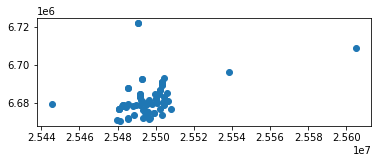

In [1]:
import geopandas as gpd
from pyrosm import OSM, get_data
import pandas as pd
import geoplot as gplt
import matplotlib.pyplot as plt
import contextily as cx

# Fetch OSM data
osm = OSM(get_data("helsinki"))

# Read services from WFS provided by "Palvelukartta"
url = "https://kartta.hel.fi/ws/geoserver/avoindata/wfs?request=GetFeature&typename=avoindata:Toimipisterekisteri_palvelut&outputformat=JSON"
data = gpd.read_file(url)

# Select health facilities (that provide doctor's appointments)
health_facilities = ['terveysasemat', 'kaupungin tai kunnan sairaalat', 'yliopistolliset sairaalat', 'päiväsairaalat']

data = data.loc[data["service_fi"].isin(health_facilities)]
data.plot()


<AxesSubplot:>

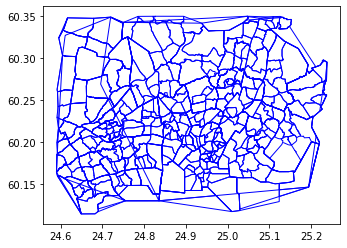

In [2]:
# Read boundaries
boundaries = osm.get_boundaries()
boundaries.plot(facecolor="none", edgecolor="blue", lw=1)

In [3]:
# Select data which is within the boundaries
data = data.to_crs(epsg=4326)
data = gpd.sjoin(data, boundaries[["geometry"]])

In [4]:
data = data[['id', 'name_en',
        'address_zip', 'address_city_en', 
        'created_time', 'modified_time',
       'service_ids', 'service_en',
       'datanomistaja', 'geometry']]

In [5]:
data.head()

,id,name_en,address_zip,address_city_en,created_time,modified_time,service_ids,service_en,datanomistaja,geometry
1566,Toimipisterekisteri_palvelut.fid-6118e1f9_1771...,Malmi Health Station,00700,Helsinki,2008-07-10,2021-01-14,703,health stations,Palvelukartta,POINT (25.00126 60.25394)
1595,Toimipisterekisteri_palvelut.fid-6118e1f9_1771...,Vuosaari Health Station,00980,Helsinki,2008-07-10,2020-11-27,703,health stations,Palvelukartta,POINT (25.14662 60.20600)
1607,Toimipisterekisteri_palvelut.fid-6118e1f9_1771...,Haaga Health Station,00400,Helsinki,2008-07-10,2020-11-27,703,health stations,Palvelukartta,POINT (24.90414 60.22225)
1636,Toimipisterekisteri_palvelut.fid-6118e1f9_1771...,Suutarila Health Station,00740,Helsinki,2008-07-10,2020-11-27,703,health stations,Palvelukartta,POINT (24.99842 60.27563)
1659,Toimipisterekisteri_palvelut.fid-6118e1f9_1771...,Puistola Health Station,00750,Helsinki,2008-07-10,2020-11-27,703,health stations,Palvelukartta,POINT (25.03449 60.27488)


In [6]:
data = data.reset_index()
data["service_en"].unique()

array(['health stations', 'city or municipal hospitals',
       'university hospitals', 'day hospitals'], dtype=object)

In [7]:
data["service_en"].value_counts()

health stations                169
university hospitals            88
city or municipal hospitals     38
day hospitals                    4
Name: service_en, dtype: int64

In [8]:
# Harmonize the name for Espoo
data["address_city_en"] = data["address_city_en"].replace(to_replace={"Espoon kaupunki": "Espoo"})
data["address_city_en"].unique()

array(['Helsinki', 'Kauniainen', 'Espoo', 'Vantaa'], dtype=object)

In [9]:
# Drop duplicates
data = data.drop_duplicates(subset=["name_en"])

In [10]:
# Rename day hospitals as city or municipal hospitals
data["service_en"] = data["service_en"].replace(to_replace={"day hospitals": "city or municipal hospitals"}).copy()

In [11]:
# Drop duplicate geometries - i.e. if there are multiple 
data["wkt"] = data["geometry"].apply(lambda geom: geom.wkt).copy()
data = data.drop_duplicates(subset=["service_en", "wkt"]).copy()

## Assign health related employees for each zipcode

Let's make the number of doctors more realistic by weighting the value based on number of workers working in health sector at a a given zipcode

In [12]:
# Figure out the available layers
from owslib.wfs import WebFeatureService
wfs = WebFeatureService("http://geo.stat.fi/geoserver/postialue/wfs")
list(wfs.contents.keys())

['postialue:pno',
 'postialue:pno_meri',
 'postialue:pno_meri_2015',
 'postialue:pno_meri_2016',
 'postialue:pno_meri_2017',
 'postialue:pno_meri_2018',
 'postialue:pno_meri_2019',
 'postialue:pno_meri_2020',
 'postialue:pno_2015',
 'postialue:pno_2016',
 'postialue:pno_2017',
 'postialue:pno_2018',
 'postialue:pno_2019',
 'postialue:pno_2020',
 'postialue:pno_tilasto',
 'postialue:pno_tilasto_2015',
 'postialue:pno_tilasto_2016',
 'postialue:pno_tilasto_2017',
 'postialue:pno_tilasto_2018',
 'postialue:pno_tilasto_2019',
 'postialue:pno_tilasto_2020']

In [13]:
# Fetch statistical grid data from PAAVO
url = 'http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2020&outputformat=JSON'
pop_zip = gpd.read_file(url)

In [14]:
# Merge information about population ('tp_q_terv')
data = data.merge(pop_zip[["tp_q_terv", "postinumeroalue"]], left_on="address_zip", right_on="postinumeroalue")
data = data.drop(["postinumeroalue"], axis=1)

In [36]:
# There are cases having multiple facilities under same postal code area
# Need to reflect that in the calculations
value_cnts = data["address_zip"].value_counts()

# Calculate how many facilities there are per zipcode
data["facilities_per_zipcode"] = data["address_zip"].apply(lambda zipcode: value_cnts.to_dict()[zipcode])

In [37]:
hki = data.loc[data["address_city_en"]=="Helsinki"].copy()
espoo = data.loc[data["address_city_en"]=="Espoo"].copy()
vantaa = data.loc[data["address_city_en"]=="Vantaa"].copy()
kauniainen = data.loc[data["address_city_en"]=="Kauniainen"].copy()

In [38]:
# Create number of doctors
# ------------------------
# Sources: https://www.laakariliitto.fi/laakariliitto/tutkimus/laakarityovoima/
# https://www.laakariliitto.fi/site/assets/files/5223/2019_terveyskeskustilanne_yksittaiset_terveyskeskukset_2019.pdf
# https://www.hel.fi/toihinsoteen/fi/laakariksi-helsinkiin/


# Number of doctors on average in Finland is 3.8 per 1000 invididuals
# Helsinki has 656229 inhabitants
# Meaning that the number of doctors in Helsinki is ~2500

hki_doctors = (656229/1000)*3.8
espoo_doctors = (291439/1000)*3.8
vantaa_doctors = (235911/1000)*3.8
kauniainen_doctors = 9

# In hospitals there are on average 50 % of the doctors and 25 % are in health care centers
uni_hospital_share = 0.55
muni_hospital_share = 0.20 # includes other as well
healthcare_center_share = 0.25

In [39]:
# Number of health stations
hki_healthstat_cnt = hki["service_en"].value_counts()["health stations"]
vantaa_healthstat_cnt = vantaa["service_en"].value_counts()["health stations"]
espoo_healthstat_cnt = espoo["service_en"].value_counts()["health stations"]
kauniainen_healthstat_cnt = kauniainen["service_en"].value_counts()["health stations"]

# Number of doctors per station
hki_doctors_per_station = (hki_doctors * healthcare_center_share) / hki_healthstat_cnt
vantaa_doctors_per_station = (vantaa_doctors * healthcare_center_share) / vantaa_healthstat_cnt
espoo_doctors_per_station = (espoo_doctors * healthcare_center_share) / espoo_healthstat_cnt

In [40]:
print(f"Helsinki doctors per station (n={hki_healthstat_cnt})", hki_doctors_per_station)
print(f"Vantaa doctors per station (n={vantaa_healthstat_cnt})", vantaa_doctors_per_station)
print(f"Espoo doctors per station (n={espoo_healthstat_cnt})", espoo_doctors_per_station)

Helsinki doctors per station (n=24) 25.97573125
Vantaa doctors per station (n=6) 37.352574999999995
Espoo doctors per station (n=11) 25.16973181818182


In [41]:
# Number of Uni hospitals
hki_unihosp_cnt = hki["service_en"].value_counts()["university hospitals"]
vantaa_unihosp_cnt = vantaa["service_en"].value_counts()["university hospitals"]
espoo_unihosp_cnt = espoo["service_en"].value_counts()["university hospitals"]

# Number of doctors per Uni hospital
hki_doctors_per_unihosp = (hki_doctors * uni_hospital_share) / hki_unihosp_cnt
vantaa_doctors_per_unihosp = (vantaa_doctors * uni_hospital_share) / vantaa_unihosp_cnt
espoo_doctors_per_unihosp = (espoo_doctors * uni_hospital_share) / espoo_unihosp_cnt

In [42]:
print(f"Helsinki doctors per Uni hospital (n={hki_unihosp_cnt})", hki_doctors_per_unihosp)
print(f"Vantaa doctors per Uni hospital (n={vantaa_unihosp_cnt})", vantaa_doctors_per_unihosp)
print(f"Espoo doctors per Uni hospital (n={espoo_unihosp_cnt})", espoo_doctors_per_unihosp)

Helsinki doctors per Uni hospital (n=15) 91.43457400000001
Vantaa doctors per Uni hospital (n=2) 246.526995
Espoo doctors per Uni hospital (n=3) 203.03583666666668


In [43]:
# Number of Muni hospitals
hki_munihosp_cnt = hki["service_en"].value_counts()["city or municipal hospitals"]
vantaa_munihosp_cnt = vantaa["service_en"].value_counts()["city or municipal hospitals"]
espoo_munihosp_cnt = espoo["service_en"].value_counts()["city or municipal hospitals"]

# Number of doctors per Muni hospital
hki_doctors_per_munihosp = (hki_doctors * muni_hospital_share) / hki_munihosp_cnt
vantaa_doctors_per_munihosp = (vantaa_doctors * muni_hospital_share) / vantaa_munihosp_cnt
espoo_doctors_per_munihosp = (espoo_doctors * muni_hospital_share) / espoo_munihosp_cnt

In [44]:
print(f"Helsinki doctors per Municipal hospital (n={hki_munihosp_cnt})", hki_doctors_per_munihosp)
print(f"Vantaa doctors per Municipal hospital (n={vantaa_munihosp_cnt})", vantaa_doctors_per_munihosp)
print(f"Espoo doctors per Municipal hospital (n={espoo_munihosp_cnt})", espoo_doctors_per_munihosp)

Helsinki doctors per Municipal hospital (n=6) 83.12234000000001
Vantaa doctors per Municipal hospital (n=1) 179.29236
Espoo doctors per Municipal hospital (n=1) 221.49364000000003


## Calculate physician weights

Physician weights are based on the postalcode where the facility is located and the number of employees working on health sector there (gives some kind of estimate about the demand for given facility which is assumed to reflect also the number of doctors in given facility). 

In [45]:
# Average number of employees working in areas where facilities are located
hki_empl_avg = hki.drop_duplicates(subset=["address_zip"])["tp_q_terv"].mean()
vantaa_empl_avg = vantaa.drop_duplicates(subset=["address_zip"])["tp_q_terv"].mean()
espoo_empl_avg = espoo.drop_duplicates(subset=["address_zip"])["tp_q_terv"].mean()

In [46]:
print("Helsinki avg number of healthcare related employees in neighborhoods with health facility:", hki_empl_avg)
print("Vantaa avg number of healthcare related employees in neighborhoods with health facility:", vantaa_empl_avg)
print("Espoo avg number of healthcare related employees in neighborhoods with health facility:", espoo_empl_avg)

Helsinki avg number of healthcare related employees in neighborhoods with health facility: 1158.36
Vantaa avg number of healthcare related employees in neighborhoods with health facility: 926.5
Espoo avg number of healthcare related employees in neighborhoods with health facility: 846.6666666666666


In [50]:
# Assign weights
hki["weight"] = (hki["tp_q_terv"] / hki_empl_avg) / hki["facilities_per_zipcode"]
vantaa["weight"] = (vantaa["tp_q_terv"] / vantaa_empl_avg) / vantaa["facilities_per_zipcode"]
espoo["weight"] = (espoo["tp_q_terv"] / espoo_empl_avg) / espoo["facilities_per_zipcode"]

## Assign number of doctors for each health facility

In [52]:
# Helsinki
# --------
hki["physician_cnt"] = None

# Stations
mask = hki["service_en"]=="health stations"
hki.loc[mask, "physician_cnt"] = (hki_doctors_per_station * hki.loc[mask, "weight"]).round(0).astype(int)

# Uni hospitals
mask = hki["service_en"]=="university hospitals"
hki.loc[mask, "physician_cnt"] = (hki_doctors_per_unihosp * hki.loc[mask, "weight"]).round(0).astype(int)

# Municipality hospitals
mask = hki["service_en"]=="city or municipal hospitals"
hki.loc[mask, "physician_cnt"] = (hki_doctors_per_munihosp * hki.loc[mask, "weight"]).round(0).astype(int)


# Vantaa
# --------
vantaa["physician_cnt"] = None

# Stations
mask = vantaa["service_en"]=="health stations"
vantaa.loc[mask, "physician_cnt"] = (vantaa_doctors_per_station * vantaa.loc[mask, "weight"]).round(0).astype(int)

# Uni hospitals
mask = vantaa["service_en"]=="university hospitals"
vantaa.loc[mask, "physician_cnt"] = (vantaa_doctors_per_unihosp * vantaa.loc[mask, "weight"]).round(0).astype(int)

# Municipality hospitals
mask = vantaa["service_en"]=="city or municipal hospitals"
vantaa.loc[mask, "physician_cnt"] = (vantaa_doctors_per_munihosp * vantaa.loc[mask, "weight"]).round(0).astype(int)

# Espoo
# --------
espoo["physician_cnt"] = None

# Stations
mask = espoo["service_en"]=="health stations"
espoo.loc[mask, "physician_cnt"] = (espoo_doctors_per_station * espoo.loc[mask, "weight"]).round(0).astype(int)

# Uni hospitals
mask = espoo["service_en"]=="university hospitals"
espoo.loc[mask, "physician_cnt"] = (espoo_doctors_per_unihosp * espoo.loc[mask, "weight"]).round(0).astype(int)

# Municipality hospitals
mask = espoo["service_en"]=="city or municipal hospitals"
espoo.loc[mask, "physician_cnt"] = (espoo_doctors_per_munihosp * espoo.loc[mask, "weight"]).round(0).astype(int)

# Kauniainen
# ----------
# In Kauniainen, there is 1 health station with 9 doctors
kauniainen["physician_cnt"] = 9

In [53]:
# Check doctor counts
print("Helsinki physician count:", hki["physician_cnt"].sum())
print("Vantaa physician count:", vantaa["physician_cnt"].sum())
print("Espoo physician count:", espoo["physician_cnt"].sum())

Helsinki physician count: 1529
Vantaa physician count: 730
Espoo physician count: 747


In [55]:
# Merge the data 
final = pd.concat([hki, espoo, vantaa, kauniainen], ignore_index=True)

# Select only relevant columns
final = final[['name_en', 'address_zip', 'address_city_en',  
               'service_en', 'datanomistaja', 'geometry', 
               'physician_cnt']]


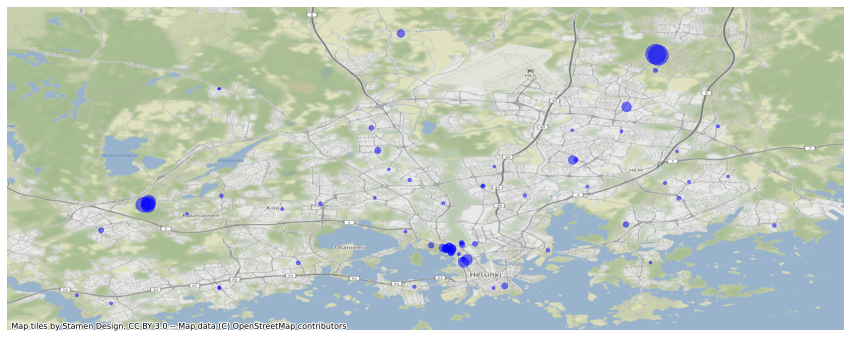

In [56]:
fig, ax = plt.subplots(figsize=(15,15))

gplt.pointplot(
                final,
                ax=ax, limits=(2.5, 20),
                scale="physician_cnt",
                lw=0.5,
                color="blue",
                alpha=0.5
)
cx.add_basemap(ax, crs=final.crs.to_string())

In [57]:
# Save to disk
final.to_file("data/hospital_data.geojson", driver="GeoJSON")